# Deep Convolutional GAN on MNIST

In [1]:
import os
import numpy as np
# from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input, Reshape, Dense, Dropout, Flatten, Conv2D, UpSampling2D
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
((X_train, _), (_,_)) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [3]:
X_train = X_train.reshape((*X_train.shape, 1))
X_train = (X_train - 127.5)/127.5
print(X_train.shape, X_train.min(), X_train.max())

(60000, 28, 28, 1) -1.0 1.0


In [0]:
adam = Adam(lr=2e-4, beta_1=0.5)

In [0]:
RANDOM_DIM = 100

In [6]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=RANDOM_DIM, kernel_initializer='normal'))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, (5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2,2)))
generator.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=adam)

W0721 00:35:03.082695 140613855815552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 00:35:03.086406 140613855815552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 00:35:03.090204 140613855815552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0721 00:35:03.116749 140613855815552 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0721 00:35:0

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [7]:
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), padding='same', input_shape=(28,28,1), strides= (2,2), kernel_initializer='normal'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5,5), padding='same', strides=(2,2)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

W0721 00:35:03.219923 140613855815552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [8]:
discriminator.trainable = False
ganInput = Input(shape=(RANDOM_DIM,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs = ganInput, outputs = ganOutput)

gan.summary()
gan.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         839937    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,052,802
Trainable params: 839,937
Non-trainable params: 212,865
_________________________________________________________________


In [0]:
def plot_images(epoch, example=100, dim=(10,10), figsize=(10,10)):
    noise = np.random.normal(0, 1, size=[example, RANDOM_DIM])
    generatedImages = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i,:,:,0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
#     plt.savefig('images/dcgan_generated_images_epoch_%d.png' %epoch)


In [0]:
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0]//batchSize
    print ("Epochs : ", epochs)
    print ("BatchSize : ", batchSize)
    print ("Batches per epoch : ", batchCount)
    
    for e in range(1, epochs+1):
        gloss, dloss = 0, 0
        print ("-"*20, "Epoch : %d" % e , "-"*20)
        
        for _ in range(batchCount):#tqdm(range(batchCount)):
            
            noise = np.random.normal(0, 1 , size=[batchSize, RANDOM_DIM])
            imageBatch = X_train[np.random.randint(0,X_train.shape[0] , size=batchSize)]
            
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])
            
            #labels
            yDis = np.zeros(2*batchSize)
            yDis[:batchSize] = 0.9
            
            #train discriminator
            discriminator.trainable = True
            dloss += discriminator.train_on_batch(X, yDis)
            
            #train generator 
            noise = np.random.normal(0, 1, size=[batchSize, RANDOM_DIM])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss += gan.train_on_batch(noise, yGen)
                
        print("Epoch %d \nDiscriminator Loss %.4f \nGenerator loss %0.4f "%((e), dloss, gloss))
        
        if e == 1 or e % 5 == 0:
            plot_images(e)
    
#     plotLoss(e)

Epochs :  50
BatchSize :  128
Batches per epoch :  468
-------------------- Epoch : 1 --------------------
Epoch 1 
Discriminator Loss 303.6581 
Generator loss 402.7856 


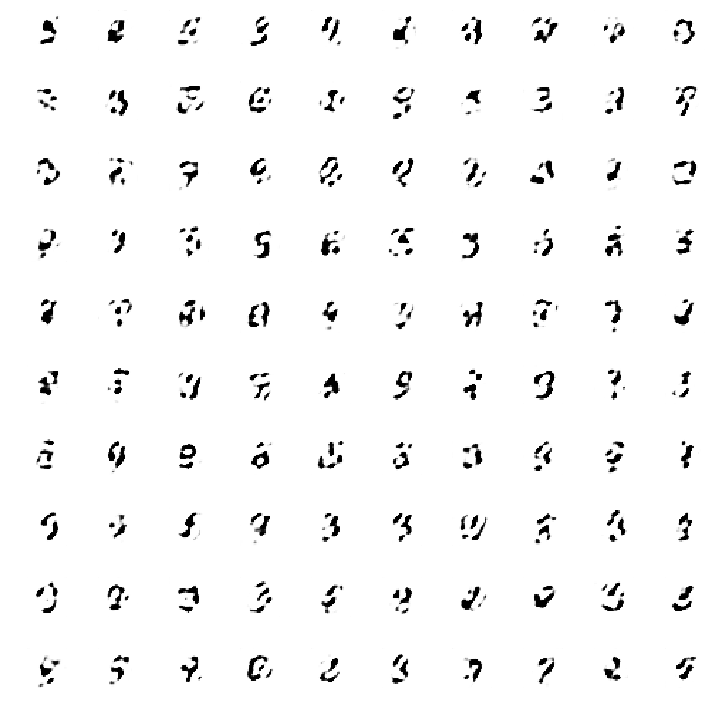

-------------------- Epoch : 2 --------------------
Epoch 2 
Discriminator Loss 286.6594 
Generator loss 455.6815 
-------------------- Epoch : 3 --------------------
Epoch 3 
Discriminator Loss 269.4211 
Generator loss 530.1475 
-------------------- Epoch : 4 --------------------
Epoch 4 
Discriminator Loss 287.5629 
Generator loss 491.7660 
-------------------- Epoch : 5 --------------------
Epoch 5 
Discriminator Loss 295.8930 
Generator loss 458.9912 


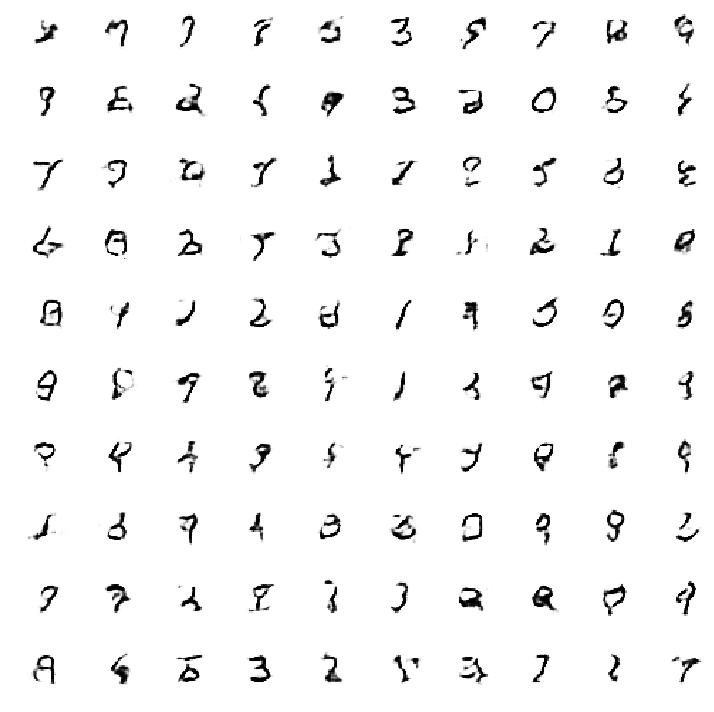

-------------------- Epoch : 6 --------------------
Epoch 6 
Discriminator Loss 297.6838 
Generator loss 453.9190 
-------------------- Epoch : 7 --------------------
Epoch 7 
Discriminator Loss 297.3178 
Generator loss 452.2328 
-------------------- Epoch : 8 --------------------
Epoch 8 
Discriminator Loss 296.0106 
Generator loss 453.0603 
-------------------- Epoch : 9 --------------------
Epoch 9 
Discriminator Loss 295.3620 
Generator loss 455.6076 
-------------------- Epoch : 10 --------------------
Epoch 10 
Discriminator Loss 293.9773 
Generator loss 462.0532 


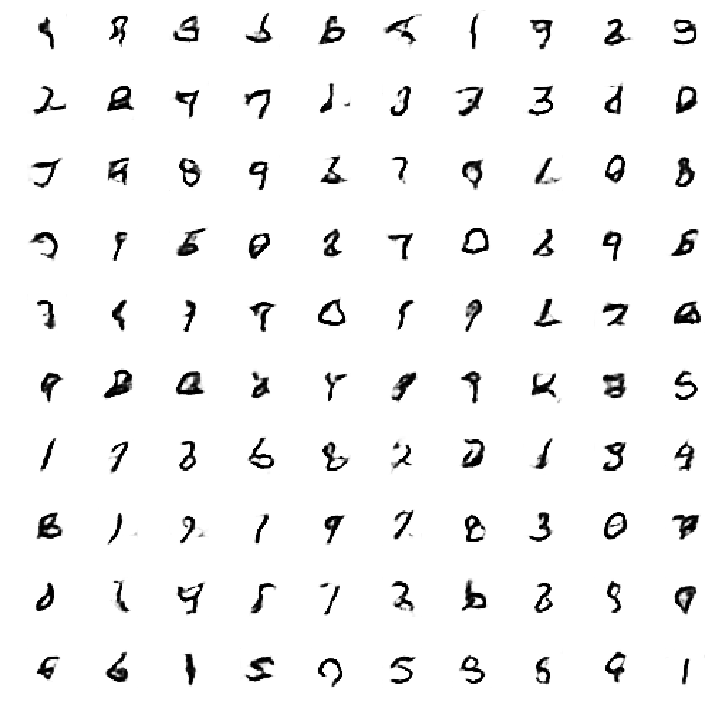

-------------------- Epoch : 11 --------------------
Epoch 11 
Discriminator Loss 292.4457 
Generator loss 467.1171 
-------------------- Epoch : 12 --------------------
Epoch 12 
Discriminator Loss 291.1242 
Generator loss 471.0456 
-------------------- Epoch : 13 --------------------
Epoch 13 
Discriminator Loss 290.3068 
Generator loss 475.5536 
-------------------- Epoch : 14 --------------------
Epoch 14 
Discriminator Loss 288.4300 
Generator loss 478.5825 
-------------------- Epoch : 15 --------------------
Epoch 15 
Discriminator Loss 288.3062 
Generator loss 484.8273 


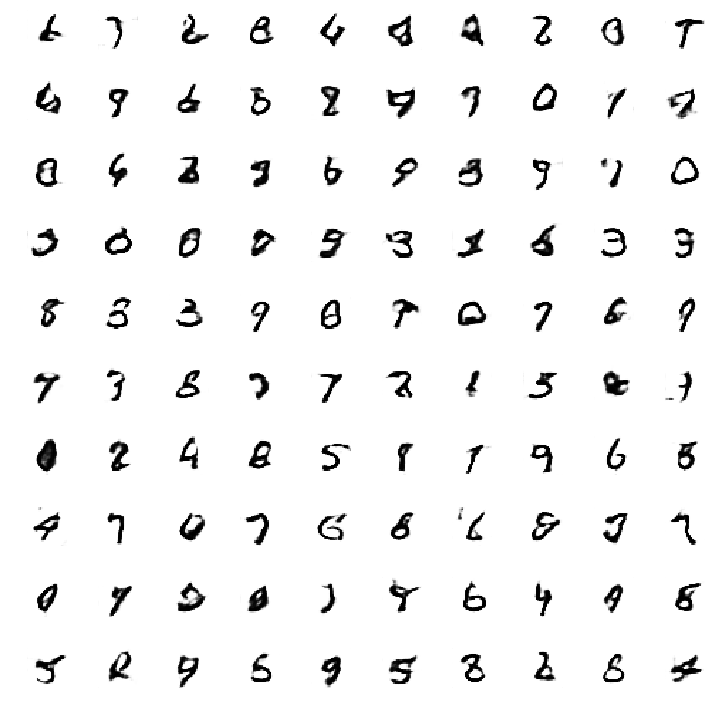

-------------------- Epoch : 16 --------------------
Epoch 16 
Discriminator Loss 287.0243 
Generator loss 484.6701 
-------------------- Epoch : 17 --------------------
Epoch 17 
Discriminator Loss 286.9533 
Generator loss 491.5178 
-------------------- Epoch : 18 --------------------
Epoch 18 
Discriminator Loss 285.0850 
Generator loss 488.3942 
-------------------- Epoch : 19 --------------------
Epoch 19 
Discriminator Loss 286.2442 
Generator loss 498.8258 
-------------------- Epoch : 20 --------------------
Epoch 20 
Discriminator Loss 284.9140 
Generator loss 496.8611 


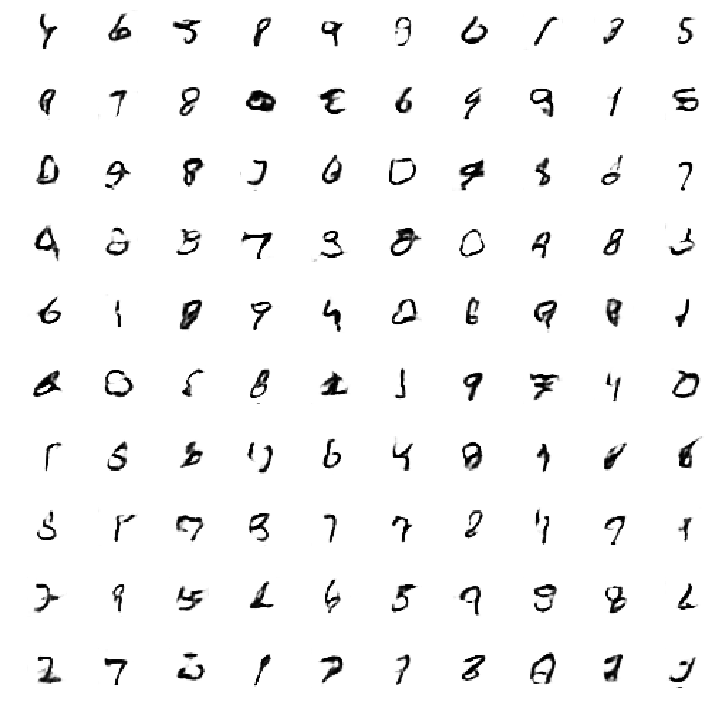

-------------------- Epoch : 21 --------------------
Epoch 21 
Discriminator Loss 284.6207 
Generator loss 499.8269 
-------------------- Epoch : 22 --------------------
Epoch 22 
Discriminator Loss 284.6161 
Generator loss 499.6287 
-------------------- Epoch : 23 --------------------
Epoch 23 
Discriminator Loss 284.1483 
Generator loss 503.7948 
-------------------- Epoch : 24 --------------------
Epoch 24 
Discriminator Loss 284.6470 
Generator loss 509.8116 
-------------------- Epoch : 25 --------------------
Epoch 25 
Discriminator Loss 283.4734 
Generator loss 508.0943 


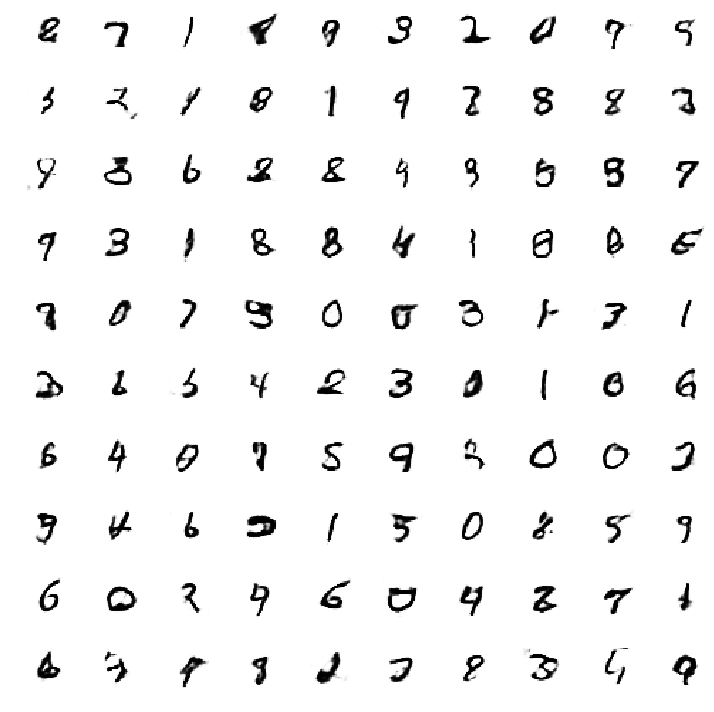

-------------------- Epoch : 26 --------------------
Epoch 26 
Discriminator Loss 282.6679 
Generator loss 506.8091 
-------------------- Epoch : 27 --------------------
Epoch 27 
Discriminator Loss 282.9485 
Generator loss 508.7004 
-------------------- Epoch : 28 --------------------
Epoch 28 
Discriminator Loss 284.2972 
Generator loss 511.1098 
-------------------- Epoch : 29 --------------------
Epoch 29 
Discriminator Loss 283.6114 
Generator loss 510.4927 
-------------------- Epoch : 30 --------------------
Epoch 30 
Discriminator Loss 282.5037 
Generator loss 512.2307 


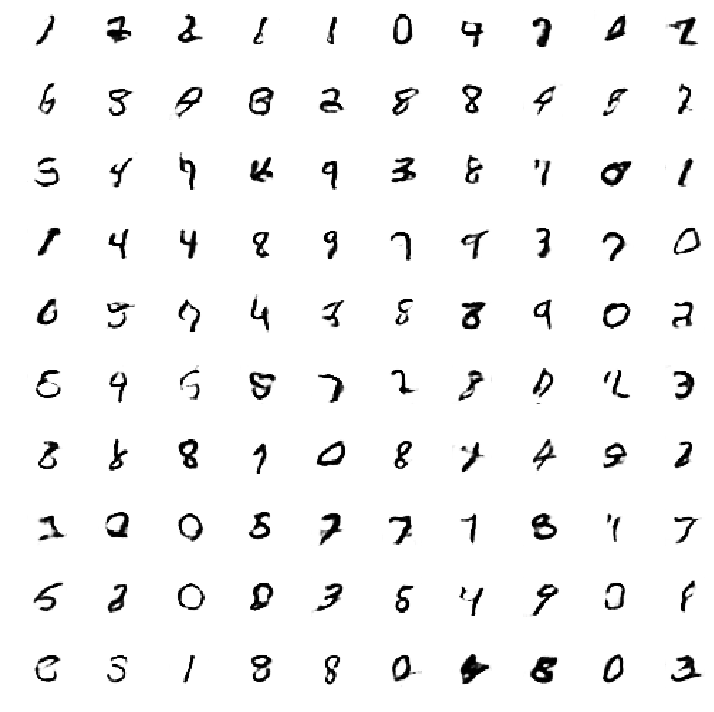

-------------------- Epoch : 31 --------------------
Epoch 31 
Discriminator Loss 283.3171 
Generator loss 509.2405 
-------------------- Epoch : 32 --------------------
Epoch 32 
Discriminator Loss 283.4101 
Generator loss 512.3488 
-------------------- Epoch : 33 --------------------
Epoch 33 
Discriminator Loss 282.4435 
Generator loss 510.2453 
-------------------- Epoch : 34 --------------------
Epoch 34 
Discriminator Loss 282.8622 
Generator loss 514.2880 
-------------------- Epoch : 35 --------------------
Epoch 35 
Discriminator Loss 282.2266 
Generator loss 514.2914 


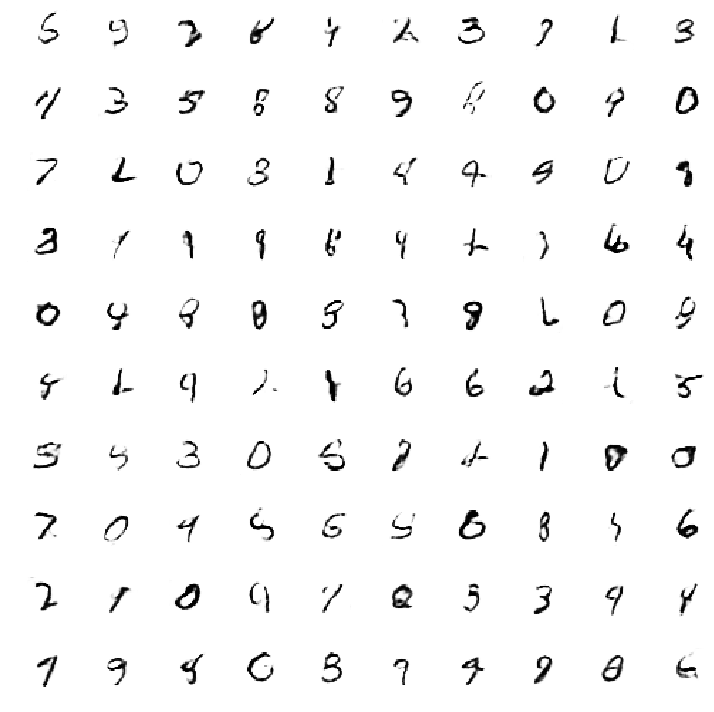

-------------------- Epoch : 36 --------------------
Epoch 36 
Discriminator Loss 283.1892 
Generator loss 517.5408 
-------------------- Epoch : 37 --------------------
Epoch 37 
Discriminator Loss 282.2274 
Generator loss 512.6586 
-------------------- Epoch : 38 --------------------
Epoch 38 
Discriminator Loss 282.1791 
Generator loss 514.1075 
-------------------- Epoch : 39 --------------------
Epoch 39 
Discriminator Loss 282.2573 
Generator loss 516.6459 
-------------------- Epoch : 40 --------------------
Epoch 40 
Discriminator Loss 282.7208 
Generator loss 514.8937 


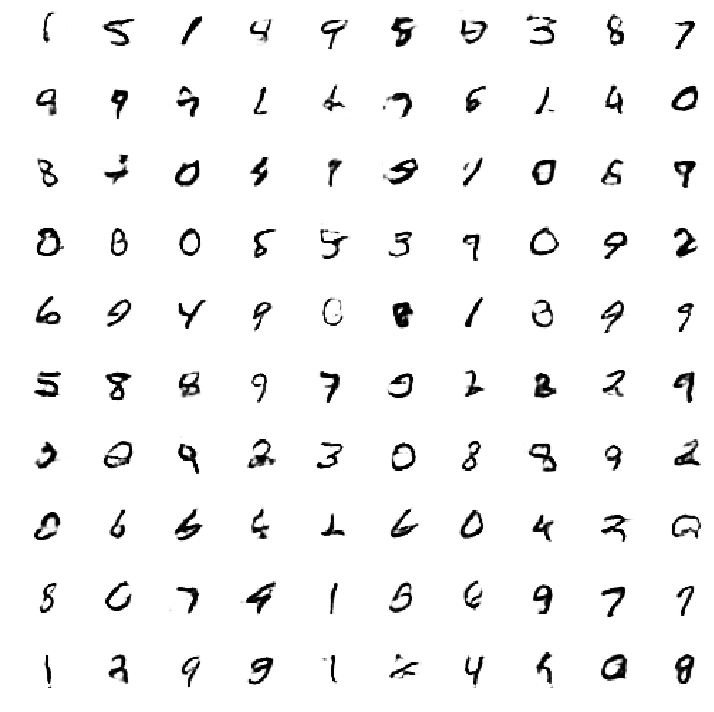

-------------------- Epoch : 41 --------------------
Epoch 41 
Discriminator Loss 282.6300 
Generator loss 512.3392 
-------------------- Epoch : 42 --------------------
Epoch 42 
Discriminator Loss 282.5621 
Generator loss 515.3373 
-------------------- Epoch : 43 --------------------
Epoch 43 
Discriminator Loss 282.6204 
Generator loss 516.5235 
-------------------- Epoch : 44 --------------------
Epoch 44 
Discriminator Loss 281.9025 
Generator loss 512.0073 
-------------------- Epoch : 45 --------------------
Epoch 45 
Discriminator Loss 283.1106 
Generator loss 517.9989 


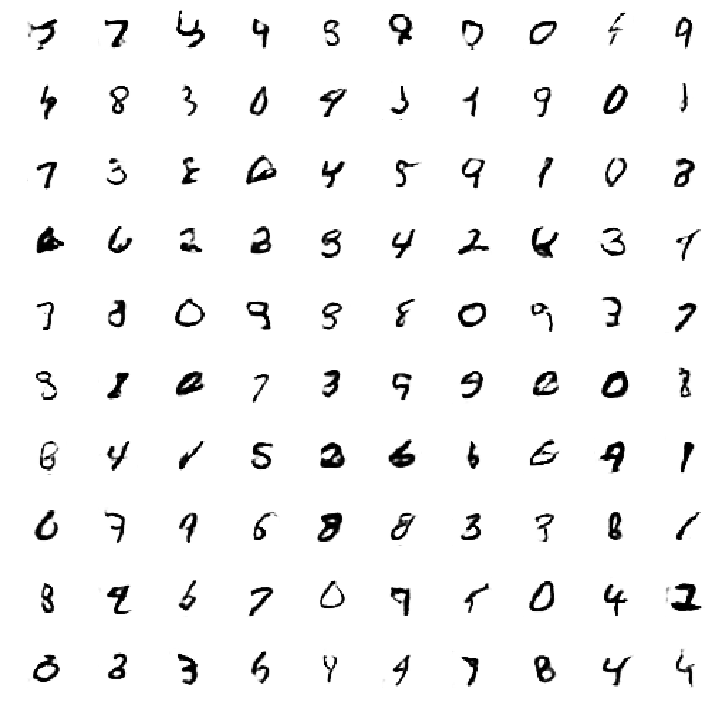

-------------------- Epoch : 46 --------------------
Epoch 46 
Discriminator Loss 282.9152 
Generator loss 514.6390 
-------------------- Epoch : 47 --------------------
Epoch 47 
Discriminator Loss 282.4671 
Generator loss 512.8851 
-------------------- Epoch : 48 --------------------
Epoch 48 
Discriminator Loss 282.1239 
Generator loss 514.1326 
-------------------- Epoch : 49 --------------------
Epoch 49 
Discriminator Loss 283.0241 
Generator loss 515.3638 
-------------------- Epoch : 50 --------------------
Epoch 50 
Discriminator Loss 283.2903 
Generator loss 514.3979 


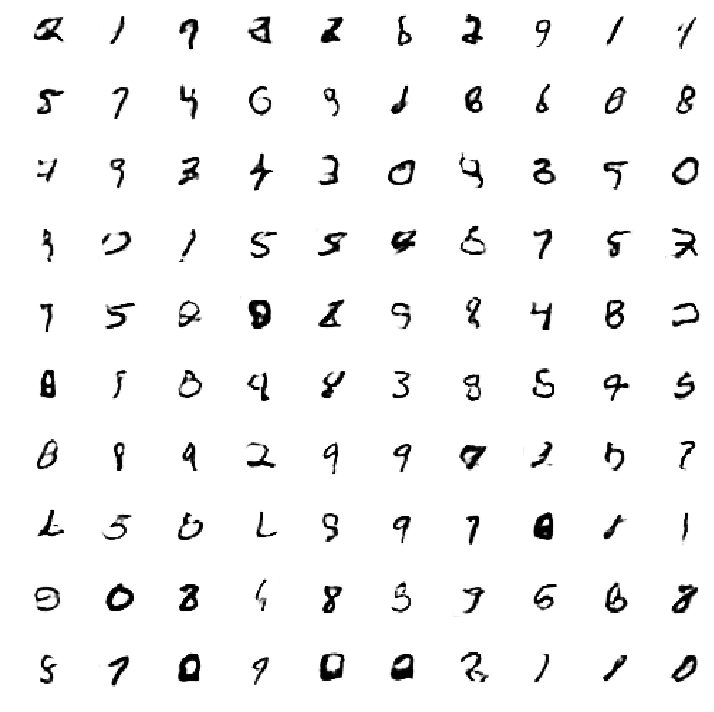

In [11]:
train(50,128)